In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from wordcloud import WordCloud
import re
import ast
import nltk 
# nltk.download('stopwords')
from nltk.corpus import stopwords 
from bertopic import BERTopic
from bertopic.representation import MaximalMarginalRelevance
from sentence_transformers import SentenceTransformer, util
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import random
from random import seed, choice
import warnings
warnings.filterwarnings("ignore")

/Users/daoming/miniconda3/envs/mit_ai_studio/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
def pre_process(df:pd.DataFrame, var:str, method:str) -> pd.DataFrame:
    df = treat_missing(df, var, method)
    df = regular_expression(df, var)
    df = remove_stopwords(df, var)
    return df
def treat_missing(df:pd.DataFrame, var:str, method:str):
    df[var] = df[var].fillna(method)
    return df
def regular_expression(df:pd.DataFrame, var:str) -> pd.DataFrame:
    # Remove dots, commas, numbers ... from the review text
    for i in range(len(df)):
        df[var].iloc[i] = re.sub(r'[0-9].', ' ', df[var].iloc[i]).lower().replace('?','').replace(',','').replace('.','').replace('!','').replace('-','').replace('(','').replace(')','').lstrip().rstrip()
    return df
def remove_stopwords(df:pd.DataFrame, var:str) -> pd.DataFrame:
    # Stopwods from nltk
    stop = stopwords.words('english')
    # Remove stopwords
    df[var] = df[var].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    return df
def check_unique(df:pd.DataFrame, var:str) -> int:
    nunique = df[var].nunique()
    print(nunique)
    if nunique < 10:
        print(df[var].unique())
def word_cloud(col):
    text = ' '.join(col)
    wordcloud = WordCloud().generate(text)
    print(f'Top freq words: {list(wordcloud.words_.keys())}')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("Wordcloud for the Amazon Reviews")
    plt.show()
def topic_bert(col,diversity):
    representation_model = MaximalMarginalRelevance(diversity=0.5)
    topic_model = BERTopic(representation_model=representation_model)
    topics,probs = topic_model.fit_transform(col)
    top_words = topic_model.get_topic_info()
    print(top_words['Representation'])
    return topic_model
def clustering_fast(df, var, min_community_size, threshold):
    clusters = util.community_detection(df1[var], min_community_size=min_community_size, threshold=threshold)
    clusters = pd.DataFrame({'sentence_ids': clusters})
    df_exploded = clusters.explode('sentence_ids')
    df_exploded['clusters_fast'] = df_exploded.index
    df_exploded.set_index('sentence_ids', inplace=True)
    df = df.merge(df_exploded, left_index=True, right_index=True)
    return df


In [4]:
# Read the data and display the dataset
df = pd.read_csv('data/7817_1.csv')
df.columns

Index(['id', 'asins', 'brand', 'categories', 'colors', 'dateAdded',
       'dateUpdated', 'dimension', 'ean', 'keys', 'manufacturer',
       'manufacturerNumber', 'name', 'prices', 'reviews.date',
       'reviews.doRecommend', 'reviews.numHelpful', 'reviews.rating',
       'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.userCity', 'reviews.userProvince', 'reviews.username', 'sizes',
       'upc', 'weight'],
      dtype='object')

# 1. EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1597 entries, 0 to 1596
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1597 non-null   object 
 1   asins                 1597 non-null   object 
 2   brand                 1597 non-null   object 
 3   categories            1597 non-null   object 
 4   colors                774 non-null    object 
 5   dateAdded             1597 non-null   object 
 6   dateUpdated           1597 non-null   object 
 7   dimension             565 non-null    object 
 8   ean                   898 non-null    float64
 9   keys                  1597 non-null   object 
 10  manufacturer          965 non-null    object 
 11  manufacturerNumber    902 non-null    object 
 12  name                  1597 non-null   object 
 13  prices                1597 non-null   object 
 14  reviews.date          1217 non-null   object 
 15  reviews.doRecommend  

In [6]:
df[['name','prices','reviews.rating','reviews.title','reviews.text','reviews.userCity','reviews.userProvince','sizes','weight']].head()

,name,prices,reviews.rating,reviews.title,reviews.text,reviews.userCity,reviews.userProvince,sizes,weight
0,Kindle Paperwhite,"[{""amountMax"":139.99,""amountMin"":139.99,""curre...",5.0,"Paperwhite voyage, no regrets!",I initially had trouble deciding between the p...,NaN,NaN,NaN,205 grams
1,Kindle Paperwhite,"[{""amountMax"":139.99,""amountMin"":139.99,""curre...",5.0,One Simply Could Not Ask For More,Allow me to preface this with a little history...,NaN,NaN,NaN,205 grams
2,Kindle Paperwhite,"[{""amountMax"":139.99,""amountMin"":139.99,""curre...",4.0,Great for those that just want an e-reader,I am enjoying it so far. Great for reading. Ha...,NaN,NaN,NaN,205 grams
3,Kindle Paperwhite,"[{""amountMax"":139.99,""amountMin"":139.99,""curre...",5.0,Love / Hate relationship,I bought one of the first Paperwhites and have...,NaN,NaN,NaN,205 grams
4,Kindle Paperwhite,"[{""amountMax"":139.99,""amountMin"":139.99,""curre...",5.0,I LOVE IT,I have to say upfront - I don't like coroporat...,NaN,NaN,NaN,205 grams


In [7]:
check_unique(df, 'weight')

9
['205 grams' '1.1 pounds' nan '1.6 ounces' '1.75 lbs' '0.8 ounces'
 '4 ounces' '5 ounces' '4.6 ounces' '2.4 ounces']


In [8]:
check_unique(df, 'brand')

2
['Amazon' 'Moshi']


In [9]:
check_unique(df, 'name')

62


In [10]:
check_unique(df, 'categories')

19


In [11]:
check_unique(df, 'colors')

3
[nan 'GB' 'Black' 'Clear']


In [12]:
# product frequency by descending order
top_names = df.groupby('name') \
.agg(count=('name','count')
    , avg_rating=('reviews.rating','mean')
    ) \
.sort_values(by='count', ascending=False) \
.reset_index('name')

top_names

,name,count,avg_rating
0,Amazon Tap - Alexa-Enabled Portable Bluetooth ...,542,4.533210
1,Amazon Fire TV,166,4.204545
2,Amazon Premium Headphones,133,4.012987
3,Fire HD 6 Tablet,87,5.000000
4,"Kindle Fire HDX 7""",70,4.391304
...,...,...,...
57,Fire Kids Edition Tablet,3,2.666667
58,Fire HDX 8.9 Tablet,3,4.333333
59,Fire HD 8 Tablet with Alexa,3,4.666667
60,Fire HD 8 Tablet,3,3.666667


<Axes: xlabel='reviews.rating', ylabel='Count'>

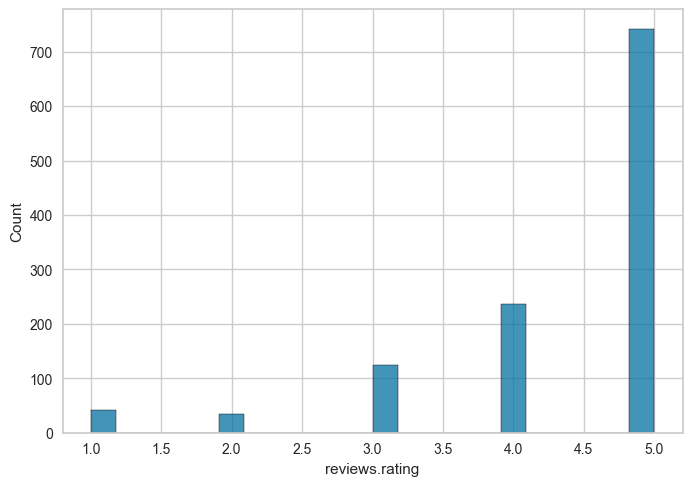

In [13]:
sns.histplot(df['reviews.rating'])

In [14]:
list(top_names.name.head())

['Amazon Tap - Alexa-Enabled Portable Bluetooth Speaker',
 'Amazon Fire TV',
 'Amazon Premium Headphones',
 'Fire HD 6 Tablet',
 'Kindle Fire HDX 7"']

<Axes: xlabel='reviews.rating', ylabel='Count'>

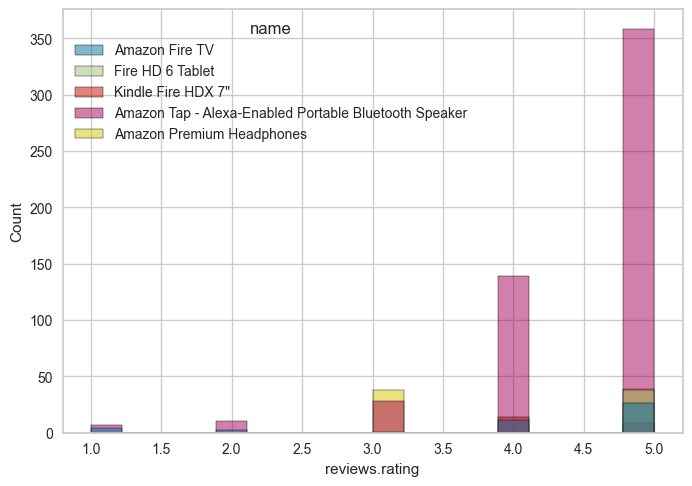

In [15]:
sns.histplot(df.merge(top_names.head(), on='name', how='inner'), x='reviews.rating', hue='name')

In [16]:
# create additional variables
df['title_text'] = df['reviews.title'] + df['reviews.text']
df[['title_text','reviews.title','reviews.text']]

,title_text,reviews.title,reviews.text
0,"Paperwhite voyage, no regrets!I initially had ...","Paperwhite voyage, no regrets!",I initially had trouble deciding between the p...
1,One Simply Could Not Ask For MoreAllow me to p...,One Simply Could Not Ask For More,Allow me to preface this with a little history...
2,Great for those that just want an e-readerI am...,Great for those that just want an e-reader,I am enjoying it so far. Great for reading. Ha...
3,Love / Hate relationshipI bought one of the fi...,Love / Hate relationship,I bought one of the first Paperwhites and have...
4,I LOVE ITI have to say upfront - I don't like ...,I LOVE IT,I have to say upfront - I don't like coroporat...
...,...,...,...
1592,I would be disappointed with myself if i produ...,I would be disappointed with myself if i produ...,This is not the same remote that I got for my ...
1593,Battery draining remote!!!!I have had to chang...,Battery draining remote!!!!,I have had to change the batteries in this rem...
1594,replacing an even worse remote. Waste of timeR...,replacing an even worse remote. Waste of time,"Remote did not activate, nor did it connect to..."
1595,OverpricedIt does the job but is super over pr...,Overpriced,It does the job but is super over priced. I fe...


In [61]:
# pre-process data
df1 = df.copy()
df1 = pre_process(df1, 'reviews.text', 'NA')
df1 = pre_process(df1, 'title_text', 'NA')

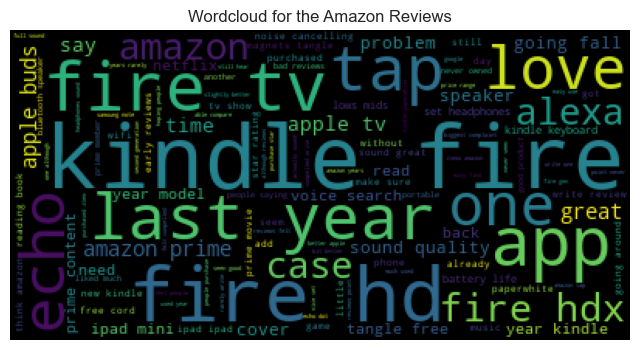

In [18]:
# word cloud
word_cloud(df1['reviews.text'])

# 2. BERTopic

In [49]:
# with reviews.text only
topic_model1 = topic_bert(df1['reviews.text'],0.5)

0    [earbuds, magnets, headphones, noise, tangle, ...
1    [headphones, around, work, earpods, bass, nice...
2    [fire, samsung, gen, note, kindles, tablets, f...
3    [sound, apples, theyre, buds, reviews, headpho...
4    [reviews, touch, ereader, secondary, ipad, kin...
5    [apples, sound, theyre, buds, reviews, headpho...
6    [camera, tablet, quality, dual, gigs, hd, amaz...
7    [roku, streaming, apple, features, remote, sma...
8    [comcast, ondemand, music, free, amazon, dvr, ...
Name: Representation, dtype: object


In [52]:
# with reviews.text and title
topic_model2 = topic_bert(df1['title_text'],0.5)

0    [sound, apples, headphones, theyre, buds, revi...
1    [earbuds, magnets, headphones, designed, noise...
2    [headphones, would, earpods, bass, hear, apple...
3    [fire, gen, samsung, review, kindles, backgrou...
4    [reviews, immediate, touch, ereader, secondary...
5    [camera, hd, tablet, quality, gigs, ads, speak...
6    [roku, streaming, apple, features, remote, sma...
7    [comcast, ondemand, music, review, amazon, wat...
Name: Representation, dtype: object


In [54]:
topic_model1.visualize_barchart(top_n_topics=8,n_words=9)

In [53]:
topic_model2.visualize_barchart(top_n_topics=8,n_words=9)

# 3. Fast Clustering + Word Cloud

In [62]:
# Create embeddings
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
df1['embedding'] = df1['reviews.text'].apply(lambda x: model.encode(x))

In [59]:
df1['embedding'].head()

0    [-0.12723438, 0.08694366, 0.18223771, 0.194478...
1    [-0.14768082, 0.029148286, 0.02993837, -0.1315...
2    [-0.32789266, 0.29943144, 0.0078035486, 0.6343...
3    [-0.16909674, -0.12992866, -0.21180004, -2.716...
4    [-0.12371918, 0.03145478, -0.10860208, -0.2278...
Name: embedding, dtype: object

In [63]:
# Fast Clustering
df1 = clustering_fast(df1, 'embedding', 20, 0.8)

Top freq words: ['apple buds', 'going fall', 'say', 'purchased items', 'items amazon', 'amazon years', 'years rarely', 'rarely write', 'write reviews', 'reviews felt', 'felt compelled', 'compelled write', 'write one', 'one although', 'although reviews', 'reviews point', 'point never', 'never seen', 'seen good', 'good product', 'bad reviews', 'hoping people', 'people purchase', 'purchase star', 'star rating', 'rating accurate', 'accurate product', 'address three', 'three biggest', 'biggest complaints', 'read others', 'sound quality', 'quality think', 'think headphones', 'headphones sound', 'sound great', 'never owned', 'owned expensive', 'expensive pair', 'able compare', 'compare higherend', 'higherend offerings', 'owned dozens', 'dozens cheap', 'cheap midrange', 'midrange headphones', 'headphones range', 'audiophile musician', 'missing something', 'something coming', 'fine ignorance', 'slightly better', 'better apple', 'buds liked', 'liked much', 'much used', 'used years', 'years recen

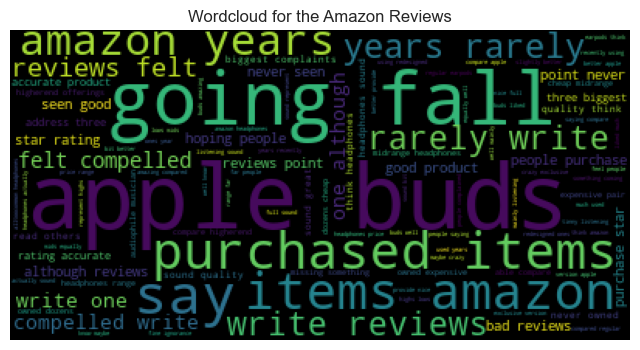

Top freq words: ['noise cancelling', 'magnets tangle', 'tangle free', 'bought couple', 'wanted earbud', 'earbud designed', 'designed noise', 'cancelling hate', 'hate shove', 'shove headphones', 'headphones brain', 'brain use', 'use apparently', 'apparently lot', 'lot people', 'people assumption', 'assumption supposed', 'supposed noise', 'cancelling something', 'something simple', 'simple earbuds', 'earbuds hate', 'hate able', 'able hear', 'hear going', 'going around', 'around feel', 'feel safe', 'safe public', 'public using', 'using headphones', 'headphones block', 'block everything', 'old style', 'style earbuds', 'earbuds stick', 'stick ears', 'ears comfortable', 'comfortable maybe', 'maybe small', 'small ears', 'ears something', 'never fall', 'fall dislodge', 'dislodge ears', 'ears cancel', 'cancel outside', 'outside noise', 'noise sit', 'sit ears', 'ears exactly', 'exactly supposed', 'supposed sound', 'sound travels', 'travels right', 'free aspects', 'aspects headphones', 'headphone

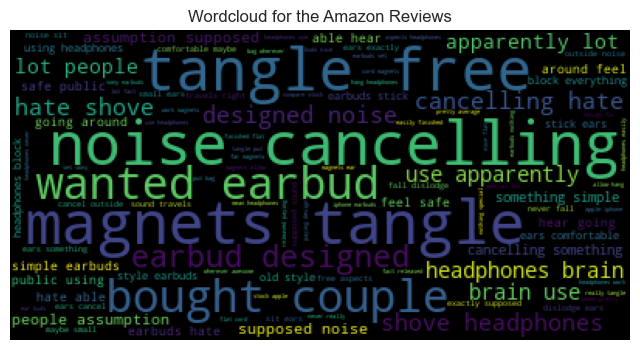

Top freq words: ['set headphones', 'nice set', 'still hear', 'volume work', 'work iphones', 'iphones please', 'please iphone', 'iphone research', 'research buying', 'buying eg', 'eg first', 'first line', 'line product', 'product description', 'description work', 'work well', 'wanted give', 'give headphones', 'headphones try', 'try preordered', 'preordered end', 'end june', 'june finally', 'finally came', 'came today', 'today got', 'got try', 'apple earpods', 'earpods headphones', 'headphones ear', 'ear comfortable', 'comfortable chance', 'chance keep', 'keep day', 'minutes hour', 'complete audiophile', 'occasional nice', 'headphones thinking', 'thinking nice', 'headphones even', 'even think', 'pretty similar', 'similar sound', 'sound earpods', 'definitely give', 'give step', 'step apple', 'apple headphones', 'headphones hands', 'thing love', 'love earpods', 'hear everything', 'everything around', 'around headphones', 'headphones way', 'way may', 'think perfect', 'perfect use', 'use aro

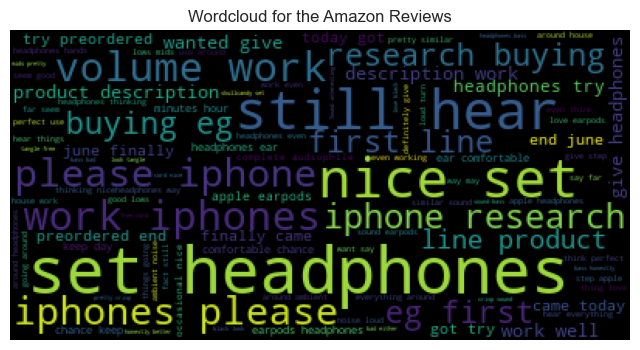

Top freq words: ['fire gen', 'samsung note', 'read fire', 'fire tv', 'tv review', 'review know', 'know tough', 'tough amazon', 'amazon comes', 'comes items', 'items needs', 'needs deliver', 'deliver quality', 'quality price', 'price point', 'point earn', 'earn stars', 'stars please', 'please take', 'take time', 'time read', 'read entire', 'entire review', 'review feel', 'feel free', 'free ask', 'ask questions', 'questions best', 'best respond', 'respond update', 'update review', 'review reflect', 'reflect answers', 'answers things', 'things discover', 'discover along', 'along wayfirst', 'wayfirst background', 'background many', 'many amazon', 'amazon kindles', 'kindles bw', 'bw fire', 'gen fire', 'gen well', 'well apple', 'apple ipad', 'ipad gen', 'gen samsung', 'note lg', 'lg g', 'g smartphone', 'smartphone samsung', 'samsung notebooks', 'notebooks chromebooks', 'chromebooks etc', 'used many', 'many products', 'products including', 'including fire', 'fire hdx', 'hdx line', 'line solid

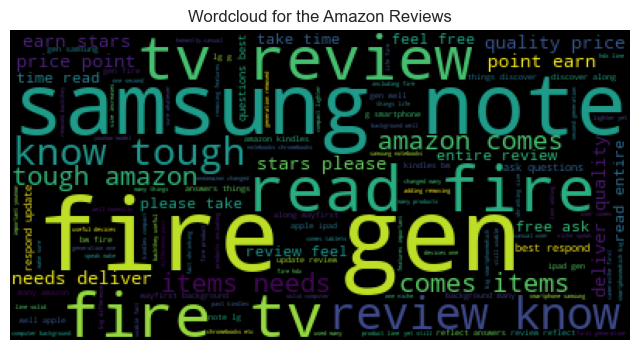

Top freq words: ['early reviews', 'preface saying', 'saying ipad', 'ipad expecting', 'expecting tablet', 'tablet perform', 'perform anywhere', 'anywhere near', 'near level', 'level followed', 'followed early', 'reviews closely', 'closely seeing', 'seeing enough', 'enough satisfied', 'satisfied customers', 'customers figured', 'give kindle', 'kindle fire', 'fire hd', 'hd try', 'try chose', 'chose base', 'base gb', 'gb special', 'special offers', 'offers plan', 'plan use', 'use secondary', 'secondary ereader', 'ereader secondary', 'secondary even', 'even tertiary', 'tertiary vehicle', 'vehicle internet', 'internet access', 'found powerful', 'powerful little', 'little tablet', 'tablet far', 'far completely', 'completely free', 'free bugs', 'bugs laggy', 'laggy speeds', 'speeds mentioned', 'mentioned early', 'reviews fact', 'fact performance', 'performance exceeded', 'exceeded expectations', 'expectations consider', 'consider perhaps', 'perhaps year', 'year best', 'best purchasefirst', 'pu

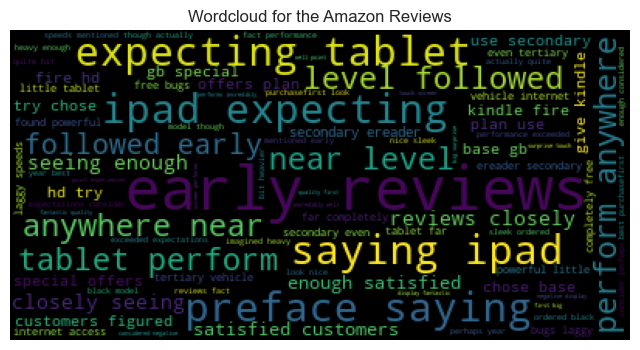

Top freq words: ['tablet want', 'dual speakers', 'low price', 'price tablet', 'tablet really', 'really expected', 'expected camera', 'camera great', 'always use', 'use phone', 'phone camera', 'camera effect', 'effect pros', 'pros cons', 'cons pros', 'pros low', 'low cost', 'cost yet', 'yet high', 'high tech', 'tech great', 'great screen', 'screen quality', 'quality course', 'course better', 'better looks', 'looks great', 'great smooth', 'smooth responsive', 'responsive easy', 'easy access', 'access amazon', 'amazon prime', 'prime content', 'content easy', 'easy wirelessly', 'wirelessly share', 'share content', 'content tv', 'tv battery', 'battery life', 'life web', 'web browser', 'browser works', 'works greatcons', 'greatcons apps', 'apps android', 'android users', 'users used', 'used camera', 'camera quality', 'quality great', 'great flash', 'flash less', 'less extra', "extra features'", "features' higher", 'higher priced', 'priced tablets', 'tablets havei', 'havei opted', 'opted go',

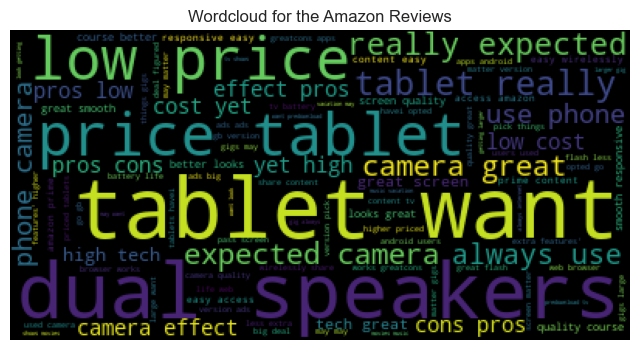

Top freq words: ['apple tv', 'streaming content', 'roku boxes', 'roku box', 'app', 'amazon', 'smart tv', 'box really', 'prime streaming', 'means roku', 'box roku', 'firetv roku', 'netflix', 'fire tv', 'casual user', 'user ondemand', 'ondemand content', 'content devices', 'devices tried', 'tried smart', 'tv brands', 'brands smart', 'smart dvd', 'dvd bluray', 'bluray players', 'players apple', 'tv wdtv', 'wdtv htpc', 'htpc chromecast', 'chromecast many', 'many competing', 'competing products', 'products mentionfor', 'mentionfor streaming', 'content box', 'really two', 'two options', 'options simple', 'simple use', 'use box', 'box require', 'require additional', 'additional items', 'items tweaking', 'first apple', 'tv easy', 'easy use', 'use interface', 'interface apple', 'apple limits', 'limits content', 'greatly including', 'including prime', 'streaming built', 'built lacks', 'lacks lot', 'lot features', 'features well', 'well slow', 'slow reason', 'reason selecting', 'selecting apple',

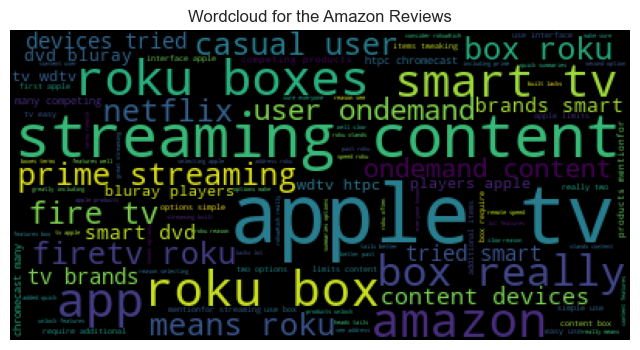

Top freq words: ['comcast ondemand', 'typical middleaged', 'middleaged woman', 'woman game', 'super techsavvy', 'techsavvy meansso', 'meansso take', 'take review', 'review fire', 'fire tv', 'tv easy', 'easy install', 'loving features', 'features free', 'free movies', 'movies music', 'music simple', 'simple interface', 'interface thing', 'thing even', 'even screen', 'screen saver', 'saver comes', 'comes listening', 'listening music', 'always comcast', 'comcast cable', 'cable service', 'service without', 'without dvr', 'dvr occasionally', 'occasionally used', 'used comcast', 'ondemand watch', 'watch rent', 'rent movies', 'never watch', 'watch comcast', 'comcast voice', 'voice recognition', 'recognition software', 'software amazing', 'amazing brought', 'brought exactly', 'exactly looking', 'looking every', 'every single', 'single time', 'time searched', 'searched easy', 'easy find', 'find looking', 'looking unlike', 'unlike comcast', 'amazon prime', 'prime member', 'member want', 'want vi

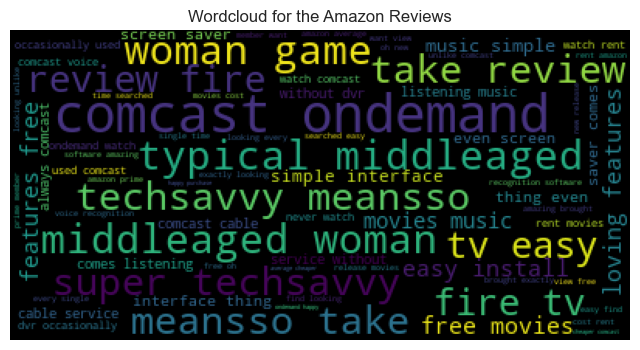

In [64]:
# Word cloud by clusters
for i in range(8):
    word_cloud(df1[df1['clusters_fast']==i]['reviews.text'])

# Bonus 1: Extra data pre-processing

In [44]:
df['prices'] = df['prices'].apply(ast.literal_eval)
df_prices = df.explode('prices')
df_parsed = df_prices['prices'].apply(pd.Series)
# df_parsed
df_final = pd.concat([df.drop(columns=['prices']), df_parsed], axis=1)

In [45]:
df_parsed.head()

,amountMax,amountMin,currency,dateAdded,dateSeen,isSale,merchant,shipping,sourceURLs,condition,availability,offer,returnPolicy,warranty
0,139.99,139.99,USD,2017-07-18T23:52:58Z,"[2017-07-15T18:10:23.807Z, 2016-03-16T00:00:00Z]",false,Amazon.com,FREE Shipping.,[https://www.amazon.com/Kindle-Paperwhite-High...,NaN,NaN,NaN,NaN,NaN
0,119.99,119.99,EUR,2016-03-08T20:21:53Z,[2016-01-29T00:00:00Z],false,Amazon EU Sarl,free,[http://www.amazon.co.uk/Kindle-Paperwhite-Res...,new,NaN,NaN,NaN,NaN
0,139.99,139.99,CAD,2016-03-08T20:21:53Z,[2016-01-11T00:00:00Z],false,Amazon,free,[http://www.amazon.ca/dp/B00QJDU3KY],new,NaN,NaN,NaN,NaN
0,119.99,119.99,USD,2016-03-08T20:21:53Z,[2016-03-12T00:00:00Z],true,Amazon.com,NaN,[http://www.amazon.com/Kindle-Paperwhite-High-...,NaN,NaN,NaN,NaN,NaN
0,119.99,119.99,EUR,2016-03-08T20:21:53Z,[2015-11-15T00:00:00Z],false,Amazon,free,[http://www.amazon.co.uk/All-New-Kindle-Paperw...,new,NaN,NaN,NaN,NaN


In [46]:
df_final.groupby('isSale').agg(avg_rating=('reviews.rating','mean'))

,avg_rating
isSale,
false,4.417196
true,4.362576


In [48]:
df_final.groupby('merchant').agg(avg_rating=('reviews.rating','mean')).sort_values(by='avg_rating',ascending=False)

,avg_rating
merchant,
Amazon.ca,4.666667
Bestbuy.com,4.533210
Kmart,4.533210
homedepot.com,4.533210
Amazon.com,4.472057
Amazon,4.202899
Amazon EU Sarl,4.166667
Tech2Date,4.012987
easy-to-open packaging,3.885870


In [50]:
df_final.groupby('shipping').agg(avg_rating=('reviews.rating','mean')).sort_values(by='avg_rating',ascending=False)

,avg_rating
shipping,
FREE Shipping.,4.428363
free,4.236111
FREE,4.204545
USD 5.99,4.204545
FREE Shipping on orders over USD 25.00,4.125628
FREE Shipping,4.012987
FREE Shipping on eligible orders.,4.012987
FREE Shipping on orders over USD 25or get FREE Two-Day Shipping with Free Shipping for Prime Members,4.012987
FREE Shipping on orders over USD 35.00,4.012987


# Bonus 2: Fine Tune with LLM Embeddings 

# Bonus 3: Sentiment Modeling